In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [3]:
import joblib 
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor 
from sklearn.metrics import mean_squared_error, r2_score

In [13]:
path = r'../dataset/dataset_v3.csv'    
df = pd.read_csv(path, parse_dates=['Date'])
df = df.sort_values("Date")
df = df.reset_index(drop=True)
df.head()

,Date,Close,Volume,CPIAUCSL,FEDFUNDS,sp500,usd_index,Open_prev,High_prev,Low_prev,...,Close_pct_change86,Close_pct_change88,Close_pct_change90,Close_pct_change92,Close_pct_change94,Close_pct_change96,Close_pct_change98,Close_pct_change100,Close_pct_change102,Close_pct_change104
0,2001-02-15,255.100006,23.0,176.0,5.49,1326.609985,113.199997,260.000000,260.000000,259.399994,...,-5.693159,-5.553499,-5.728012,-6.075110,-6.761696,-8.369249,-6.931777,-5.623375,-6.178738,-6.316556
1,2001-02-16,258.200012,2.0,176.0,5.49,1301.530029,112.260002,259.500000,259.500000,255.100006,...,-6.584653,-5.212916,-4.121788,-4.476499,-5.455875,-6.313495,-5.732012,-5.003670,-4.014865,-4.863663
2,2001-02-20,256.100006,24.0,176.0,5.49,1278.939941,112.820000,255.000000,258.500000,255.000000,...,-5.983843,-5.323473,-5.183265,-5.358463,-5.706922,-6.396199,-8.010053,-6.566946,-5.253416,-5.810956
3,2001-02-21,258.200012,40.0,176.0,5.49,1255.270020,113.120003,256.100006,256.100006,255.000000,...,-4.898706,-6.584653,-5.212916,-4.121788,-4.476499,-5.455875,-6.313495,-5.732012,-5.003670,-4.014865
4,2001-02-22,258.500000,16.0,176.0,5.49,1252.819946,113.339996,256.700012,258.200012,256.600006,...,-4.647734,-5.102788,-4.436229,-4.294708,-4.471547,-4.823272,-5.519008,-7.147986,-5.691356,-4.365515


**Greedy algorithm to find optimal lags to track inflation rate trend**

In [4]:
def pct_change_lags_greedy_search(df_original):
    pct_change_lags = []
    r2_scores = []
    mse_scores = []
    lag = 1

    while True: 
        pct_change_lags.append(lag)

        df = df_original.copy()

        for l in pct_change_lags:
            df[f'CPIAUCSL_pct_change{l}'] = df['CPIAUCSL'].pct_change(periods=l) * 100

        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(inplace=True)
        df.reset_index(drop=True, inplace=True)

        target_col = 'Close'
        features = [col for col in df.columns if col not in ['Date', target_col]]

        #--- Scale features
        scaler = MinMaxScaler()
        df[features] = scaler.fit_transform(df[features])

    
        X = df[features]
        y = df[target_col]  

        assert len(X) == len(y), f"Mismatch: X={len(X)}, y={len(y)}"

        split_index = int(len(df) * 0.8)
        X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
        y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

        xgb = XGBRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )
        xgb.fit(X_train, y_train)

        y_pred = xgb.predict(X_test)

        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        r2_scores.append(r2)
        mse_scores.append(mse)

        if lag >= 250:
            break

        lag += 2

    # Plot results
    plt.figure(figsize=(14, 6))
    plt.title('Greedy Search: CPIAUCSL Percentage Change Lags vs Model Performance')
    plt.plot(pct_change_lags, mse_scores, label='MSE Score', color='orange')
    plt.plot(pct_change_lags, r2_scores, label='R² Score', color='blue')
    plt.xlabel('Number of Lags for % Change')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    best_r2 = max(r2_scores)
    best_lag = pct_change_lags[r2_scores.index(best_r2)]
    print(f"\nBest R² = {best_r2:.4f} at lag = {best_lag}")

C:\Users\User\AppData\Local\Temp\ipykernel_16788\3910646574.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'CPIAUCSL_pct_change{l}'] = df['CPIAUCSL'].pct_change(periods=l) * 100
C:\Users\User\AppData\Local\Temp\ipykernel_16788\3910646574.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'CPIAUCSL_pct_change{l}'] = df['CPIAUCSL'].pct_change(periods=l) * 100
C:\Users\User\AppData\Local\Temp\ipykernel_16788\3910646574.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

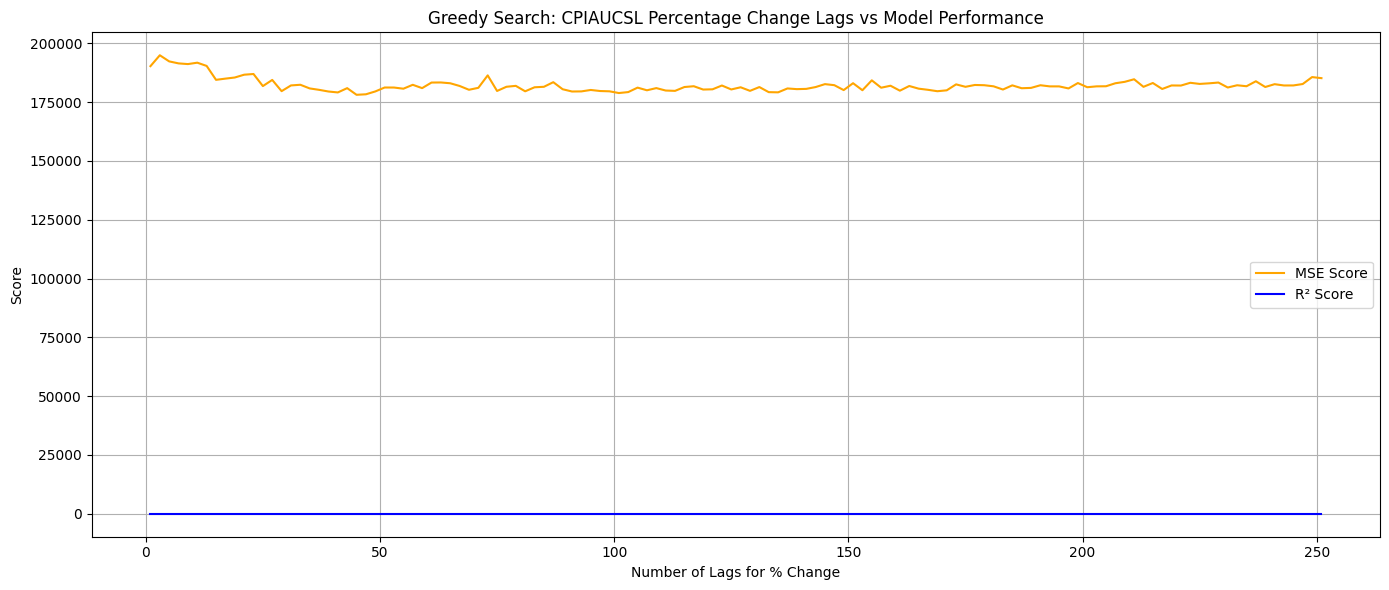


Best R² = -0.0297 at lag = 217


In [5]:
pct_change_lags_greedy_search(df)

In [6]:
def greedy_lag_search(df_original, max_lag=250, step=2):
    selected_lags = []
    r2_scores = []
    mse_scores = []
    best_r2 = -np.inf

    available_lags = list(range(1, max_lag + 1, step))

    while available_lags:
        best_candidate_lag = None
        best_candidate_r2 = best_r2
        best_candidate_mse = None

        for lag in available_lags:
            temp_lags = selected_lags + [lag]
            df = df_original.copy()

            # Add lagged features
            for l in temp_lags:
                df[f'CPIAUCSL_lag{l}'] = df['CPIAUCSL'].shift(l)

            df.replace([np.inf, -np.inf], np.nan, inplace=True)
            df.dropna(inplace=True)
            df.reset_index(drop=True, inplace=True)

            if df.empty:
                continue

            # Define features and target
            target_col = 'Close'
            features = [col for col in df.columns if col not in ['Date', target_col]]

            # Scale features
            scaler = MinMaxScaler()
            df[features] = scaler.fit_transform(df[features])

            X = df[features]
            y = df[target_col]

            split_index = int(len(df) * 0.8)
            X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
            y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

            if len(X_train) == 0 or len(X_test) == 0:
                continue

            # Train model
            model = XGBRegressor(
                n_estimators=500,
                learning_rate=0.05,
                max_depth=6,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                verbosity=0
            )
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            r2 = r2_score(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)

            # Update best candidate
            if r2 > best_candidate_r2:
                best_candidate_r2 = r2
                best_candidate_mse = mse
                best_candidate_lag = lag

        if best_candidate_lag is not None:
            selected_lags.append(best_candidate_lag)
            available_lags.remove(best_candidate_lag)
            r2_scores.append(best_candidate_r2)
            mse_scores.append(best_candidate_mse)
            best_r2 = best_candidate_r2
            print(f"Added lag {best_candidate_lag}, R² = {best_candidate_r2:.4f}")
        else:
            print("No improvement found — stopping search.")
            break

    # Plot results
    plt.figure(figsize=(14, 6))
    plt.title('Greedy Search: CPIAUCSL Lags vs Model Performance')
    plt.plot(range(1, len(r2_scores) + 1), mse_scores, label='MSE Score', color='orange')
    plt.plot(range(1, len(r2_scores) + 1), r2_scores, label='R² Score', color='blue')
    plt.xlabel('Greedy Step (# of Lags Selected)')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"\nBest R² = {best_r2:.4f} using lags: {selected_lags}")
    return selected_lags, r2_scores, mse_scores

Added lag 185, R² = -0.0109
No improvement found — stopping search.


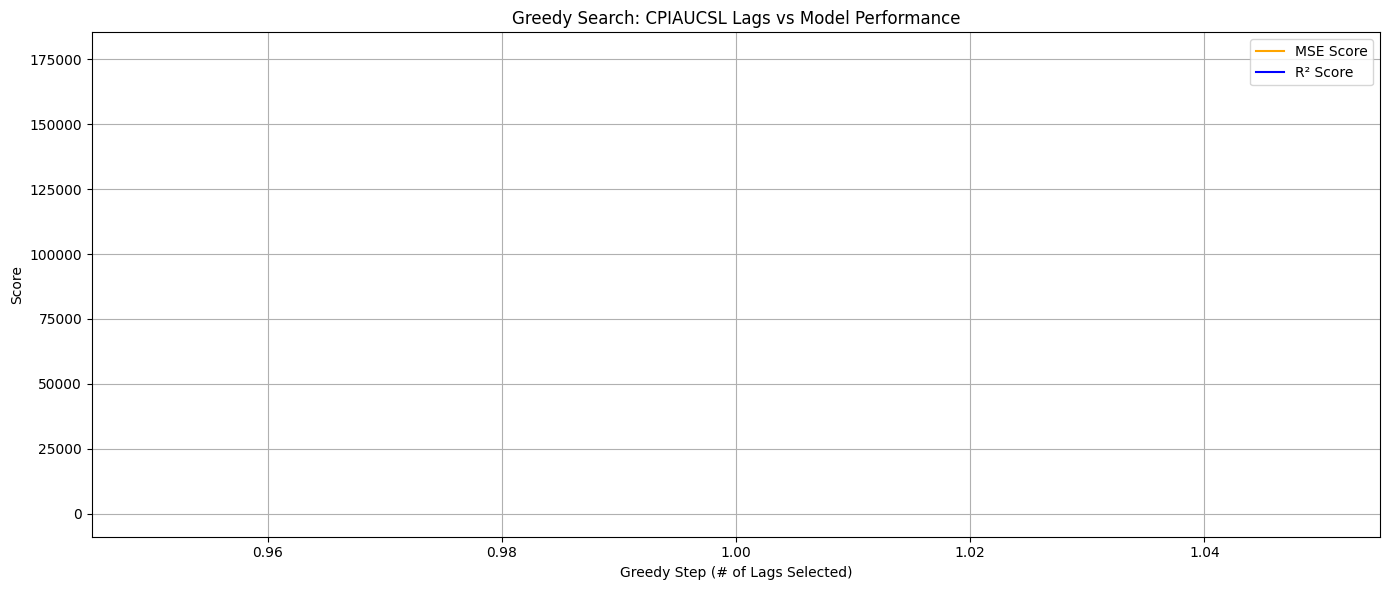


Best R² = -0.0109 using lags: [185]


([185], [-0.01085275261327645], [176526.75362341397])

In [7]:
greedy_lag_search(df)

**Trying to make improvement using the date**

In [14]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day_of_year'] = df['Date'].dt.dayofyear
df['time_index'] = np.arange(len(df))

In [15]:
df.head()

,Date,Close,Volume,CPIAUCSL,FEDFUNDS,sp500,usd_index,Open_prev,High_prev,Low_prev,...,Close_pct_change94,Close_pct_change96,Close_pct_change98,Close_pct_change100,Close_pct_change102,Close_pct_change104,year,month,day_of_year,time_index
0,2001-02-15,255.100006,23.0,176.0,5.49,1326.609985,113.199997,260.000000,260.000000,259.399994,...,-6.761696,-8.369249,-6.931777,-5.623375,-6.178738,-6.316556,2001,2,46,0
1,2001-02-16,258.200012,2.0,176.0,5.49,1301.530029,112.260002,259.500000,259.500000,255.100006,...,-5.455875,-6.313495,-5.732012,-5.003670,-4.014865,-4.863663,2001,2,47,1
2,2001-02-20,256.100006,24.0,176.0,5.49,1278.939941,112.820000,255.000000,258.500000,255.000000,...,-5.706922,-6.396199,-8.010053,-6.566946,-5.253416,-5.810956,2001,2,51,2
3,2001-02-21,258.200012,40.0,176.0,5.49,1255.270020,113.120003,256.100006,256.100006,255.000000,...,-4.476499,-5.455875,-6.313495,-5.732012,-5.003670,-4.014865,2001,2,52,3
4,2001-02-22,258.500000,16.0,176.0,5.49,1252.819946,113.339996,256.700012,258.200012,256.600006,...,-4.471547,-4.823272,-5.519008,-7.147986,-5.691356,-4.365515,2001,2,53,4


In [16]:
target = ['Close']
features = [col for col in df.columns if col not in ['Date', target]]

scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

path = r'../scalers/scaler6.pkl'
joblib.dump(scaler, path)

['../scalers/scaler6.pkl']

In [18]:
X = df[features]
y = df[target]

split_index = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


R² Score: -0.0396
Mean Squared Error: 0.0175


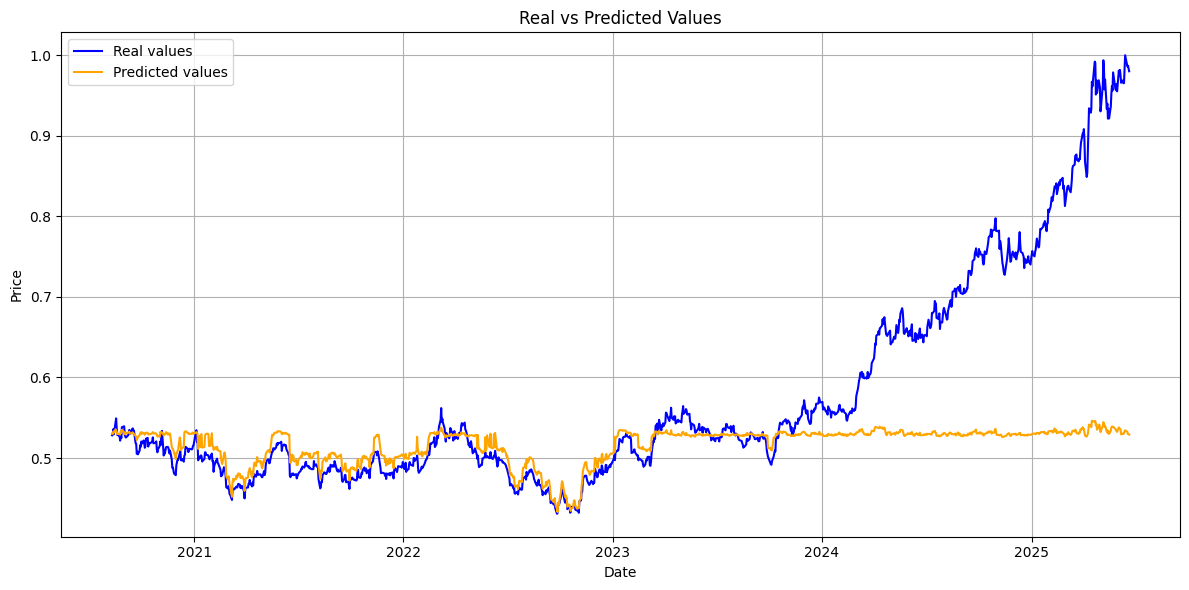

In [19]:
y_pred = xgb.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

df['Date'] = pd.to_datetime(df['Date'])

date_test = df['Date'].iloc[split_index:]

plt.figure(figsize=(12, 6))
plt.plot(date_test, y_test, label='Real values', color='blue')
plt.plot(date_test, y_pred, label='Predicted values', color='orange')

plt.title('Real vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()